In [1]:
import os
import numpy as np
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Concatenate, Flatten, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [2]:
input_shape = (224, 224, 3)
dataset_dir= r"C:\Users\m1355\Documents\WeChat Files\wxid_z0qpzwe8erfg22\FileStorage\File\2023-06\crc_skin_data\crc_skin_data"
batch_size = 4
num_classes =1

In [3]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)  # 20% of the data will be used for validation

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    os.path.join(dataset_dir, 'train'),
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary',
    subset='training')  # Use the training subset of the data

validation_generator = train_datagen.flow_from_directory(
    os.path.join(dataset_dir, 'train'),
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary',
    subset='validation')  # Use the validation subset of the data

test_generator = test_datagen.flow_from_directory(
    os.path.join(dataset_dir, 'test'),
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='binary')

# Rest of the code remains the same...


Found 400 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [4]:
class Attention(tf.keras.layers.Layer):
    def __init__(self, channels):
        super(Attention, self).__init__()
        self.channels=channels
        self.conv1= Conv2D(self.channels, kernel_size=1, strides=1, padding='valid')
        self.conv2= Conv2D(self.channels, kernel_size=1, strides=1, padding='valid')
        
    def call(self, inputs):
        x = self.conv1(inputs)
        x = tf.nn.relu(x)
        x = self.conv2(x)
        x = tf.nn.softmax(x, axis=-1) # height x width x Channel (224x224x3)
        return x
    

In [5]:
# Define the Attention model
def attention_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Convolutional layers
    conv1 = Conv2D(96, kernel_size=(11, 11), strides=(4, 4), activation='relu')(inputs)
    pool1 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(conv1)
    conv2 = Conv2D(256, kernel_size=(5, 5), activation='relu')(pool1)
    pool2 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(conv2)
    conv3 = Conv2D(384, kernel_size=(3, 3), activation='relu')(pool2)
    conv4 = Conv2D(384, kernel_size=(3, 3), activation='relu')(conv3)
    conv5 = Conv2D(256, kernel_size=(3, 3), activation='relu')(conv4)
    pool3 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(conv5)
    
    # Attention layer
    attention = Attention(channels=256)(pool3)
    
    # Apply attention to the feature map
    attention_maps = tf.multiply(pool3, attention)
    concatenate_maps = Concatenate()([pool3, attention_maps])
    
    flatten = Flatten()( concatenate_maps)
    
    # Fully connected layers
    fc1 = Dense(4096, activation='relu')(flatten)
    dropout1 = Dropout(0.5)(fc1)
    fc2 = Dense(4096, activation='relu')(dropout1)
    dropout2 = Dropout(0.5)(fc2)
    output = Dense(num_classes, activation='softmax')(dropout2)
    
    model = Model(inputs=inputs, outputs=output)
    
    return model
    

In [6]:
# Create Attention model


model = attention_model(input_shape, num_classes)

In [7]:


# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 54, 54, 96)   34944       ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 26, 26, 96)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 22, 22, 256)  614656      ['max_pooling2d[0][0]']      

In [9]:
# Train the model
history=model.fit(train_generator,epochs=2,validation_data=validation_generator,verbose=1)

Epoch 1/2
100/100 [==============================] - 11s 36ms/step - loss: 1.0263 - accuracy: 0.5000 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 2/2
100/100 [==============================] - 3s 33ms/step - loss: 0.6979 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000


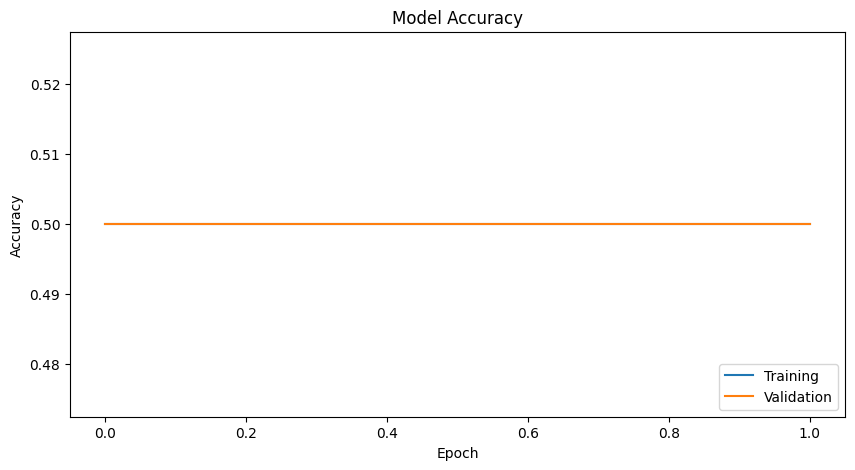

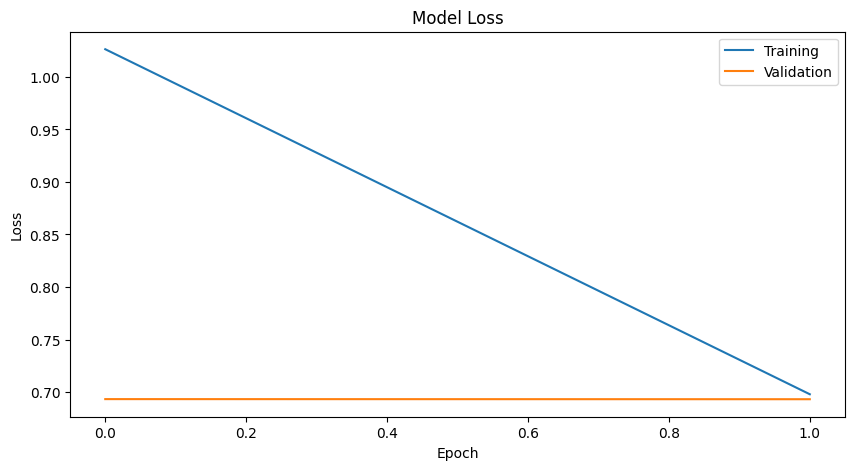

In [10]:
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()


plt.figure(figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [11]:
# Evaluate the model on the testing dataset
test_loss, test_acc = model.evaluate(test_generator)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

25/25 [==============================] - 0s 12ms/step - loss: 0.6932 - accuracy: 0.5000
Test loss: 0.6931553483009338
Test accuracy: 0.5


In [12]:
from keras import backend as K
import gc

K.clear_session()
gc.collect()

del model

In [13]:
# you will need to install numba using "pip install numba"
from numba import cuda

cuda.select_device(0)
cuda.close()